# Reaction-diffusion models of biological invasions (Fisher KPP, heterogeneous domain & covariates, PINNs and SPINNs)

$$
\begin{cases}
\frac{\partial}{\partial t} u(t,x)=D\Delta u(t,x) + u(t,x)(r(x) - \gamma u(t,x)), t\geq 0, x\in [0, 1]^2\\
\frac{\partial u(t,x)}{\partial n}\Big|_{x\in\partial\Omega}=\nabla u(t,x)\cdot n=0, t\geq0,\text{Neumann condition},\\
u(0,x)=u_0(x),x\in [0,1]^2
\end{cases}
$$

In all that follows,$\gamma$ et $D$ are considered known constant but $r(x)$ is a unknown varying constant.

This notebook is inspired from [_Parameter estimation for reaction-diffusion models of biological invasions_](https://link.springer.com/article/10.1007/s10144-013-0415-0) by Soubeyrand and Roques, 2014. It contains $3$ sections:

1) General set up
2) PINN solving with RAR sampling and spatially heterogeneous $r$ parameter
3) PINN solving with RAR sampling and spatially heterogeneous $r$ parameter using covariates
4) SPINN solving
5) Conclusion (Speed avantage for the SPINNs!)

## 1) Imports and general set up

In [15]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import our package

In [16]:
import jinns

Import other dependencies

In [17]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
import matplotlib.pyplot as plt

key = random.PRNGKey(2)

Create the neural network architecture for the PINN with `equinox`. Note that we will use the same architecture for the 3 populations.

In [18]:
eqx_list = (
    (eqx.nn.Linear, 3, 20),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 20, 20),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 20, 20),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 20, 20),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 20, 1),
)
key, subkey = random.split(key)
u, init_nn_params = jinns.nn.PINN_MLP.create(
    key=subkey, eqx_list=eqx_list, eq_type="PDENonStatio"
)

Create a DataGenerator object

In [19]:
n = 2048
nb = 500
ni = 500
domain_batch_size = 32
border_batch_size = 32
initial_batch_size = 32
dim = 2
xmin = 0
xmax = 1
ymin = 0
ymax = 1
tmin = 0
tmax = 1
method = "uniform"

Tmax = 2
key, subkey = random.split(key)
train_data = jinns.data.CubicMeshPDENonStatio(
    key=subkey,
    n=n,
    nb=nb,
    ni=ni,
    domain_batch_size=domain_batch_size,
    border_batch_size=border_batch_size,
    initial_batch_size=initial_batch_size,
    dim=dim,
    min_pts=(xmin, ymin),
    max_pts=(xmax, ymax),
    tmin=tmin,
    tmax=tmax,
    method=method,
)

## Set up the initial condition

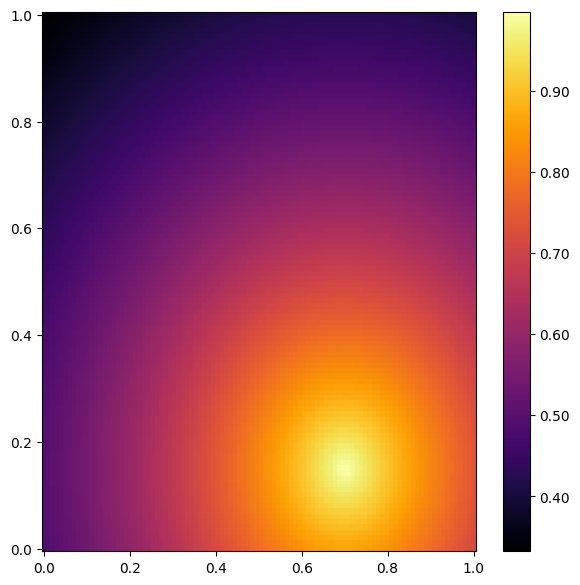

In [20]:
sigma_init = 1 * jnp.ones((2))
mu_init = jnp.array([0.7, 0.15])


def u0(x):
    return jnp.exp(-jnp.linalg.norm(x - mu_init))


nx, ny = 100, 100
val_xy_data = [jnp.linspace(xmin, xmax, nx), jnp.linspace(ymin, ymax, ny)]

jinns.plot.plot2d(fun=u0, xy_data=val_xy_data, title="u0(x,y)")

## 1) Spatial heterogeneity of $r$

### True model parameters

We need to load the matrix containing the r values

In [21]:
D = 0.05
g = 1.0
r1, r2, r3 = 0.0, -4.0, 2.0

A set of parameters as required by the losses' `evaluate` functions is a dictionary with the neural network parameters `nn_params` and the equation parameters `eq_params`. Here we construct this dictionary

In [22]:
init_params = jinns.parameters.Params(
    nn_params=init_nn_params,
    eq_params={"D": jnp.array([D]), "r": jnp.array([r1, r2, r3]), "g": jnp.array([g])},
)

The spatial heterogeneity of $r$ is introduced through a user defined function which recreates the spatial map

In [23]:
def r_fun(t_x, _, params):
    """must be a jittable function"""
    eq_params = params.eq_params
    r1, r2, r3 = eq_params.r
    x = t_x[1:]
    return jax.lax.switch(
        jnp.amax(
            jnp.nonzero(
                jnp.array(
                    [
                        True,
                        jnp.logical_or(
                            jnp.logical_and(x[0] > 6 / 20, x[0] < 8 / 20),
                            jnp.logical_and(x[1] > 8 / 20, x[1] < 10 / 20),
                        ),
                        jnp.logical_or(
                            (x[0] - 0.15) ** 2 + (x[1] - 0.15) ** 2 < 0.015,
                            (x[0] - 0.8) ** 2 + (x[1] - 0.80) ** 2 < 0.03,
                        ),
                    ]
                ),
                size=3,
            )[0]
        ),
        [lambda _: r1, lambda _: r2, lambda _: r3],
        (),
    )

Let's visualize the spatial heterogeneity map that we have just created:

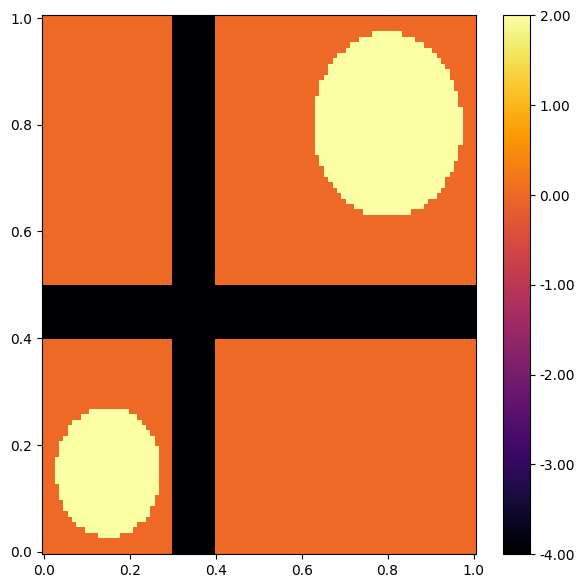

In [24]:
nx, ny = 100, 100
val_xy_data = [jnp.linspace(xmin, xmax, nx), jnp.linspace(ymin, ymax, ny)]

jinns.plot.plot2d(
    fun=lambda x: r_fun(
        jnp.concatenate([jnp.array([0.0]), x], axis=0), None, init_params
    ),
    xy_data=val_xy_data,
    title="u0(x,y)",
)

### Loss construction
Create the Reaction Diffusion 2D loss.

Importantly, the loss contains **heterogeneous parameters** (*i.e.* which possibly depends on `t`, `x` and `params`). This can be managed by defining a dictionary `eq_params_heterogeneity` where keys match the ones in `eq_params` at the initialization of `Params`, and values can be by any kind of jit-able function that returns equation parameters.  Here, the $r$ coefficient is varies spatially according to the `r_fun` defined above. Thus, we simply set this function to the key `"r"` of the `eq_params_heterogeneity` dictionary. Note that whatever the transform, the signature of such a function must be `t, x, u, params` in the non-stationary case we are dealing with here.

The rest of the implementation is as-usal in **jinns** : we define the `eqx.Module` subclassing `PDENonStatio` with its `equation` method. The parameters heterogeneity will be handled internally by the package.

In [25]:
fisher_dynamic_loss = jinns.loss.FisherKPP(
    Tmax=Tmax,
    eq_params_heterogeneity={"D": None, "r": r_fun, "g": None},
    dim_x=2,
    params=init_params,
)

In [26]:
loss_weights = jinns.loss.LossWeightsPDENonStatio(
    dyn_loss=1, initial_condition=1 * Tmax, boundary_loss=1 * Tmax
)

loss = jinns.loss.LossPDENonStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=fisher_dynamic_loss,
    boundary_condition=jinns.loss.Neumann(),
    initial_condition_fun=u0,
    params=init_params,
)

In [27]:
# Testing the loss function
losses_and_grad = jax.value_and_grad(loss, 0, has_aux=True)
losses, grads = losses_and_grad(init_params, train_data.get_batch()[1])


l_tot, d = losses
print(f"total loss: {l_tot}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in d.items()} }")

total loss: 0.8385008573532104
Individual losses: {'dyn_loss': '0.41', 'boundary_loss': '0.00', 'initial_condition': '0.22'}


### Learning the neural network parameters
The learning process here consider known equation parameters `eq_params`. We thus only update `nn_params`

In [28]:
params = init_params

In [29]:
# Optimizer
import optax

tx = optax.adam(learning_rate=1e-3)

In [30]:
n_iter = 50000

In [31]:
params, total_loss_list, loss_by_term_dict, train_data, loss, _, _, _, _, _, _, _ = (
    jinns.solve(
        init_params=params,
        data=train_data,
        optimizer=tx,
        loss=loss,
        n_iter=n_iter,
    )
)

Initialization time: 3.0028553009033203

Compilation took
 8.037092447280884 

[train] Iteration 0: loss value = 0.822527289390564
[train] Iteration 1000: loss value = 0.42805272340774536
[train] Iteration 2000: loss value = 0.3999430537223816
[train] Iteration 3000: loss value = 0.47719162702560425
[train] Iteration 4000: loss value = 0.3917522132396698
[train] Iteration 5000: loss value = 0.3121347427368164
[train] Iteration 6000: loss value = 0.2654249668121338
[train] Iteration 7000: loss value = 0.333962619304657
[train] Iteration 8000: loss value = 0.2085098922252655
[train] Iteration 9000: loss value = 0.21080990135669708
[train] Iteration 10000: loss value = 0.18033182621002197
[train] Iteration 11000: loss value = 0.1546611338853836
[train] Iteration 12000: loss value = 0.16648760437965393
[train] Iteration 13000: loss value = 0.16312569379806519
[train] Iteration 14000: loss value = 0.14359161257743835
[train] Iteration 15000: loss value = 0.15253694355487823
[train] Iteratio

### Results

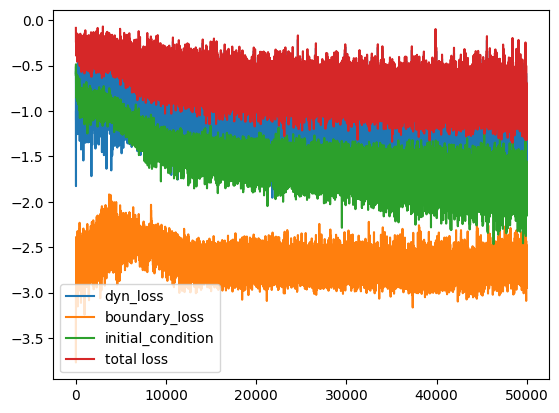

In [32]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();

Plot the PDE solution learned by the PINN

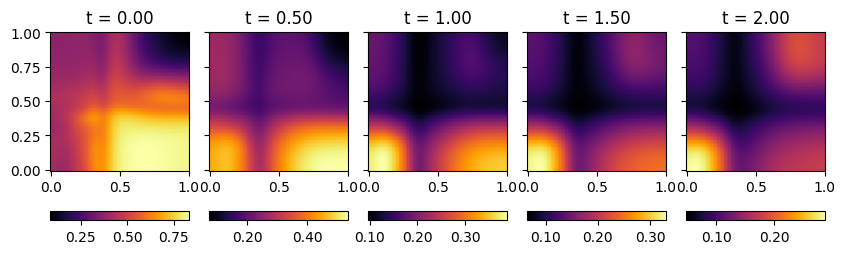

In [33]:
times = [0, 0.25, 0.5, 0.75, 1]  # times in the rescaled time susescale
u_est = lambda t_x: u(t_x, params)
jinns.plot.plot2d(
    fun=u_est,
    xy_data=val_xy_data,
    times=times,
    Tmax=Tmax,
    title="u0(x,y)",
    figsize=(10, 10 * len(times)),
)

## 2) Spatial heterogeinity of $r$ through a GLM 

This section is inspired from mechanico-statistical model in ecology as e.g.
 [this article](https://www.sciencedirect.com/science/article/pii/S2211675320300221?via%3Dihub) 
 and [accompanying code](https://github.com/oliviergimenez/appendix_mecastat/blob/01a89e8d2506849b28ec9da6fa7dec0a3be61050/mecastat_simulations.R#L127)). 

Let us say that we have access to an addition spatial covariate, $c(x)$ 
which corresponds to forest covering at position $x$. We make the hypothesis 
that the reproduction rate $r(x)$ spatially depends on $c(x)$ through the 
following logistic link
$$
  r(x) = \frac{1}{1 + e^{\beta_0 + \beta_1 c(x) + \beta_2 c(x)^2}}
$$

Here, $\beta$ is supposed known and fixed but one could optimize w.r.t to 
$\beta$ in inverse problem settings.

In [34]:
# Here is an unusual jinns call needed to change the equation parameters!!
from jinns.parameters import EqParams

EqParams.clear()

In [35]:
D = 0.05
g = 1.0
r0 = 0.0

init_params = jinns.parameters.Params(
    nn_params=init_nn_params,
    eq_params={
        "D": jnp.array([D]),
        "r": jnp.array([r0]),
        "g": jnp.array([g]),
        "beta": jnp.array([-2.0, 1.0, 5.0]),
    },
)

We now specify how we get the covariate value at point $x$. Here, we say say the covariate is accessible everywhere and disposed on a map (for simplicity we take the same as before).

In [36]:
def covariate(x):
    """must be a jittable function"""
    f1, f2, f3 = 0.5, 0.0, 0.9
    return jax.lax.switch(
        jnp.amax(
            jnp.nonzero(
                jnp.array(
                    [
                        True,
                        jnp.logical_or(
                            jnp.logical_and(x[0] > 6 / 20, x[0] < 8 / 20),
                            jnp.logical_and(x[1] > 8 / 20, x[1] < 10 / 20),
                        ),
                        jnp.logical_or(
                            (x[0] - 0.15) ** 2 + (x[1] - 0.15) ** 2 < 0.015,
                            (x[0] - 0.8) ** 2 + (x[1] - 0.80) ** 2 < 0.03,
                        ),
                    ]
                ),
                size=3,
            )[0]
        ),
        [lambda _: f1, lambda _: f2, lambda _: f3],
        (),
    )

In [37]:
def r_fun(t_x, _, params):
    """must be a jittable function"""
    # t is never used here since no temporal modeling
    # but we could have covariate(t_x) in a non-stationary setting
    c = covariate(t_x[1:])
    return jax.nn.sigmoid(jnp.sum(params.eq_params.beta * jnp.array([1, c, c**2])))

Text(0.5, 1.0, 'Generalized linear model: $b(r) = \\beta^\\top (1, c, c^2)$.')

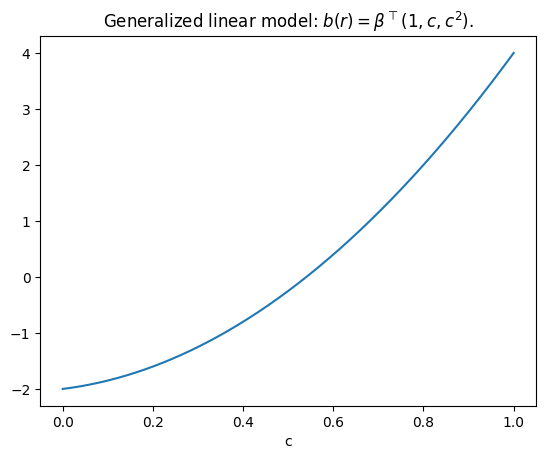

In [38]:
cs = jnp.linspace(0, 1, 1000)
plt.plot(
    cs,
    vmap(lambda c: jnp.sum(init_params.eq_params.beta * jnp.array([1, c, c**2])))(cs),
)
plt.xlabel(r"c")
plt.title(r"Generalized linear model: $b(r) = \beta^\top (1, c, c^2)$.")

Let's visualize the growth rate that is obtained throught this link:

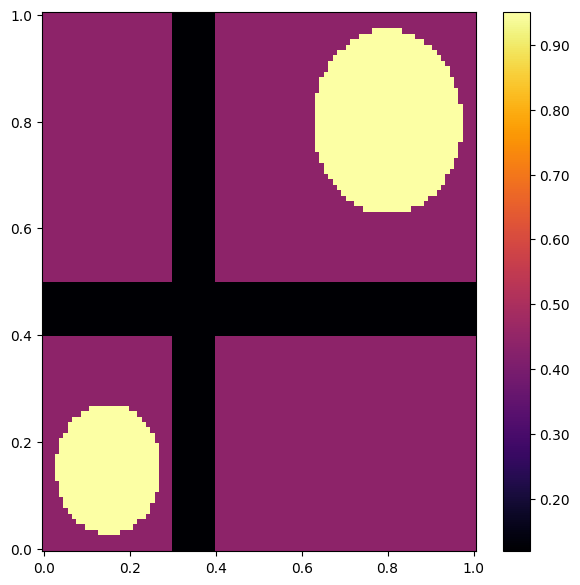

In [39]:
nx, ny = 100, 100
val_xy_data = [jnp.linspace(xmin, xmax, nx), jnp.linspace(ymin, ymax, ny)]


jinns.plot.plot2d(
    fun=lambda x: r_fun(jnp.concatenate([jnp.array([0.0]), x]), None, init_params),
    xy_data=val_xy_data,
    title="u0(x,y)",
)

Then the rest follows as in the previous section

In [40]:
fisher_dynamic_loss = jinns.loss.FisherKPP(
    Tmax=Tmax,
    eq_params_heterogeneity={"D": None, "r": r_fun, "g": None, "beta": None},
    dim_x=2,
    params=init_params,
)

In [41]:
# recreate train_data because rar_sampling was previously used on another
# problem => reset the collocation points
key, subkey = random.split(key)
train_data = jinns.data.CubicMeshPDENonStatio(
    key=subkey,
    n=n,
    nb=nb,
    ni=ni,
    domain_batch_size=domain_batch_size,
    border_batch_size=border_batch_size,
    initial_batch_size=initial_batch_size,
    dim=dim,
    min_pts=(xmin, ymin),
    max_pts=(xmax, ymax),
    tmin=tmin,
    tmax=tmax,
    method=method,
)

In [42]:
loss_weights = jinns.loss.LossWeightsPDENonStatio(
    dyn_loss=1, initial_condition=1 * Tmax, boundary_loss=1 * Tmax
)

loss = jinns.loss.LossPDENonStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=fisher_dynamic_loss,
    boundary_condition=jinns.loss.Neumann(),
    initial_condition_fun=u0,
    params=init_params,
)

In [43]:
# Optimizer
import optax

params = init_params


tx = optax.adam(learning_rate=1e-3)
n_iter = 50000

params, total_loss_list, loss_by_term_dict, train_data, loss, _, _, _, _, _, _, _ = (
    jinns.solve(
        init_params=params,
        data=train_data,
        optimizer=tx,
        loss=loss,
        n_iter=n_iter,
    )
)

Initialization time: 2.536947250366211

Compilation took
 6.441290616989136 

[train] Iteration 0: loss value = 0.49202579259872437
[train] Iteration 1000: loss value = 0.0960419550538063
[train] Iteration 2000: loss value = 0.0465945266187191
[train] Iteration 3000: loss value = 0.04234915226697922
[train] Iteration 4000: loss value = 0.02570519968867302
[train] Iteration 5000: loss value = 0.02391047216951847
[train] Iteration 6000: loss value = 0.028967633843421936
[train] Iteration 7000: loss value = 0.024259600788354874
[train] Iteration 8000: loss value = 0.020601676777005196
[train] Iteration 9000: loss value = 0.024346277117729187
[train] Iteration 10000: loss value = 0.017883602529764175
[train] Iteration 11000: loss value = 0.013973517343401909
[train] Iteration 12000: loss value = 0.031085874885320663
[train] Iteration 13000: loss value = 0.024271875619888306
[train] Iteration 14000: loss value = 0.012900397181510925
[train] Iteration 15000: loss value = 0.012312963604927063

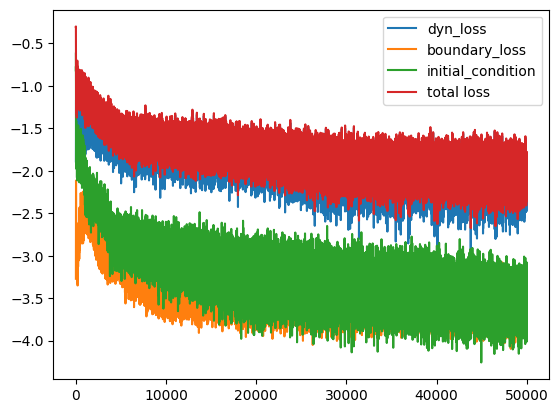

In [44]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();

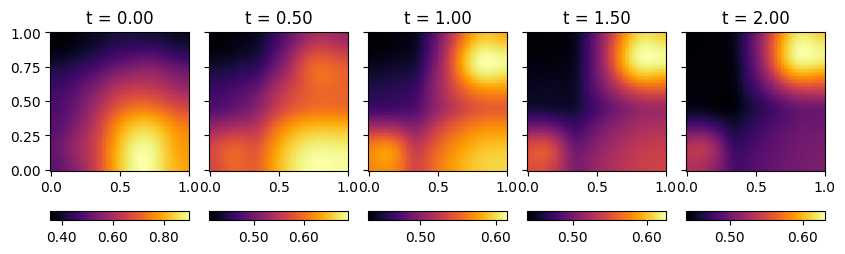

In [45]:
times = [0, 0.25, 0.5, 0.75, 1]  # times in the rescaled time susescale
u_est = lambda t_x: u(t_x, params)
jinns.plot.plot2d(
    fun=u_est,
    xy_data=val_xy_data,
    times=times,
    Tmax=Tmax,
    title="u0(x,y)",
    figsize=(10, 10 * len(times)),
)

## 3) Separable PINNs
In this section, we run experiments in the same context but with [Separable PINNs](https://openreview.net/pdf?id=dEySGIcDnI).

In [32]:
d = 3
r = 256
eqx_list = (
    (eqx.nn.Linear, 1, 128),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 128, 128),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 128, 128),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 128, r),
)
key, subkey = random.split(key)
u_spinn, init_nn_params_spinn = jinns.nn.SPINN_MLP.create(
    subkey, d, r, eqx_list, "PDENonStatio"
)

# Reset train_data: here we do not use RAR sampling as it is not implemented
# for separable-PINNs
n = 2048
nb = 500
ni = 500
domain_batch_size = 32
initial_batch_size = 32
border_batch_size = 32
dim = 2
xmin = 0
xmax = 1
ymin = 0
ymax = 1
tmin = 0
tmax = 1
method = "uniform"

Tmax = 2
key, subkey = random.split(key)
train_data = jinns.data.CubicMeshPDENonStatio(
    key=subkey,
    n=n,
    nb=nb,
    ni=ni,
    domain_batch_size=domain_batch_size,
    border_batch_size=border_batch_size,
    initial_batch_size=initial_batch_size,
    dim=dim,
    min_pts=(xmin, ymin),
    max_pts=(xmax, ymax),
    tmin=tmin,
    tmax=tmax,
    method=method,
)

### Set up the initial condition

(2,)


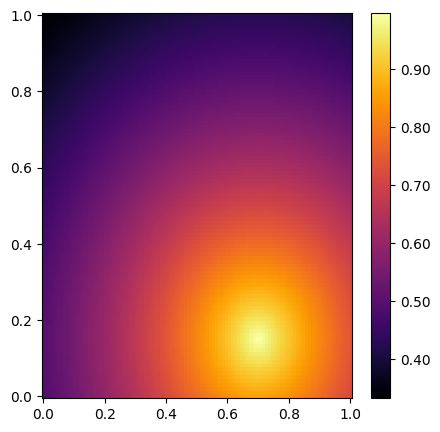

In [33]:
sigma_init = 1 * jnp.ones((2))
mu_init = jnp.array([0.7, 0.15])


def u0(x):
    print((x - mu_init).shape)
    return jnp.exp(-jnp.linalg.norm(x - mu_init, axis=-1))


nx, ny = 100, 100
val_xy_data = [jnp.linspace(xmin, xmax, nx), jnp.linspace(ymin, ymax, ny)]

jinns.plot.plot2d(fun=u0, xy_data=val_xy_data, title="u0(x,y)", figsize=(5, 5))

### Define the parameters and the spatial heterogeneity of $r$

In [34]:
D = 0.05
g = 1.0
r1, r2, r3 = 0.0, -4.0, 2.0

In [35]:
# Here is an unusual jinns call needed to change the equation parameters!!
from jinns.parameters import EqParams

EqParams.clear()

In [36]:
init_params = jinns.parameters.Params(
    nn_params=init_nn_params_spinn,
    eq_params={"D": jnp.array([D]), "r": jnp.array([r1, r2, r3]), "g": jnp.array([g])},
)

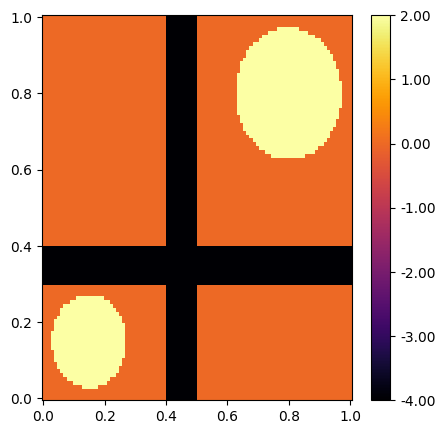

In [37]:
from jinns.utils._utils import get_grid


def r_fun(t_x, _, params):
    """must be a jittable function"""
    x = t_x[:, 1:]
    x = get_grid(x.squeeze())
    eq_params = params.eq_params
    r1, r2, r3 = eq_params.r

    # # Next is required to be able to call plot_2D and see the map
    # if x.shape[0] != x.shape[1]:
    #     x = get_grid(x.squeeze())

    # By default put r1 everywhere
    r_map_batch = jnp.full(x.shape[:2], r1)
    # But if the next cond is True, update to r2
    r_map_batch = jnp.where(
        jnp.logical_or(
            jnp.logical_and(x[..., 0] > 6 / 20, x[..., 0] < 8 / 20),
            jnp.logical_and(x[..., 1] > 8 / 20, x[..., 1] < 10 / 20),
        ),
        r2,
        r_map_batch,
    )
    # Again if the next cond is True, update to r3
    r_map_batch = jnp.where(
        jnp.logical_or(
            (x[..., 0] - 0.15) ** 2 + (x[..., 1] - 0.15) ** 2 < 0.015,
            (x[..., 0] - 0.8) ** 2 + (x[..., 1] - 0.80) ** 2 < 0.03,
        ),
        r3,
        r_map_batch,
    )
    return r_map_batch[None, ..., None]  # 1st new axis is for broacast to the
    # time dimension. Last new axis is to be the same as the u ouput we will
    # multiply with


nx, ny = 100, 100
val_xy_data = [jnp.linspace(xmin, xmax, nx), jnp.linspace(ymin, ymax, ny)]

jinns.plot.plot2d(
    fun=lambda x: r_fun(jnp.stack([jnp.zeros(x.shape), x], axis=1), None, init_params),
    xy_data=val_xy_data,
    title="u0(x,y)",
    spinn=True,
    figsize=(5, 5),
)

### Construct the loss

In [38]:
fisher_dynamic_loss = jinns.loss.FisherKPP(
    Tmax=Tmax,
    eq_params_heterogeneity={"D": None, "r": r_fun, "g": None},
    dim_x=2,
    params=init_params,
)
loss_weights = jinns.loss.LossWeightsPDENonStatio(
    dyn_loss=1, initial_condition=1 * Tmax, boundary_loss=1 * Tmax
)

loss = jinns.loss.LossPDENonStatio(
    u=u_spinn,
    loss_weights=loss_weights,
    dynamic_loss=fisher_dynamic_loss,
    boundary_condition=jinns.loss.Neumann(),
    initial_condition_fun=u0,
    params=init_params,
)

### Learning

In [39]:
params = init_params

tx = optax.adamw(learning_rate=1e-3)
n_iter = 10000
params, total_loss_list, loss_by_term_dict, train_data, loss, _, _, _, _, _, _, _ = (
    jinns.solve(
        init_params=params,
        data=train_data,
        optimizer=tx,
        loss=loss,
        n_iter=n_iter,
    )
)

/home/hugo/Documents/recherche/pinn/gitlab/jinns/loss/_DynamicLossAbstract.py:156: UserWarning: Return value from DynamicLoss' equation has more than one dimension. This is in general a mistake (probably from an unfortunate broadcast in jnp.array computations) resulting in bad reduction operations in losses.
  warnings.warn(


(32, 32, 2)
Initialization time: 3.540126085281372


/home/hugo/Documents/recherche/pinn/gitlab/jinns/utils/_utils.py:73: UserWarning: [Output of initial_condition_fun] Performing operation `-` between arrays of different shapes: got (32, 32) for the custom array and (32, 32, 1) for the PINN. This can cause unexpected and wrong broadcasting. Reshaping (32, 32) into (32, 32, 1). Reshape your custom array to math the expected_shape=(32, 32, 1) to prevent this warning.
  warnings.warn(


(32, 32, 2)

Compilation took
 16.515095472335815 

[train] Iteration 0: loss value = 1.1656906604766846
[train] Iteration 1000: loss value = 0.4376548230648041
[train] Iteration 2000: loss value = 0.23927682638168335
[train] Iteration 3000: loss value = 0.25812798738479614
[train] Iteration 4000: loss value = 0.13607047498226166
[train] Iteration 5000: loss value = 0.15713408589363098
[train] Iteration 6000: loss value = 0.18803755939006805
[train] Iteration 7000: loss value = 0.13977248966693878
[train] Iteration 8000: loss value = 0.1491212546825409
[train] Iteration 9000: loss value = 0.15142811834812164

Stopping main optimization loop, cause: max iteration is reached

Training took
 72.68418598175049 


Final iteration 10000: train loss value = 0.13662010431289673


### Results

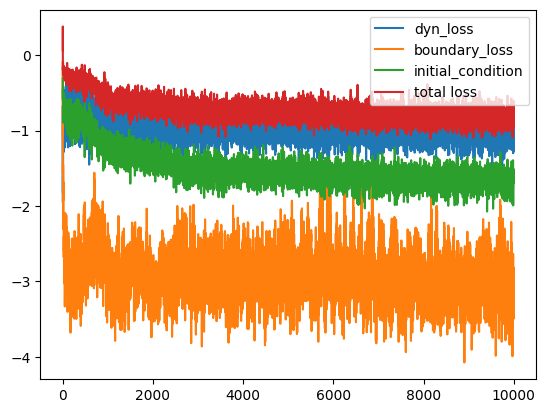

In [40]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();

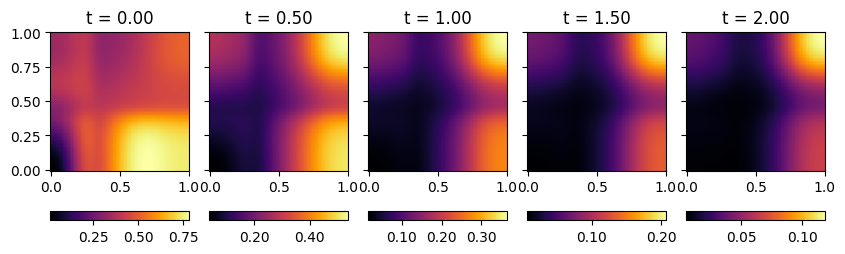

In [41]:
times = [0, 0.25, 0.5, 0.75, 1]  # times in the rescaled time susescale
u_est = lambda t_x: u_spinn(t_x, params)
jinns.plot.plot2d(
    fun=u_est,
    xy_data=val_xy_data,
    times=times,
    Tmax=Tmax,
    figsize=(10, 10 * len(times)),
    spinn=True,
)

### Solving for different initial conditions

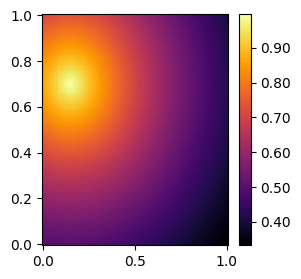

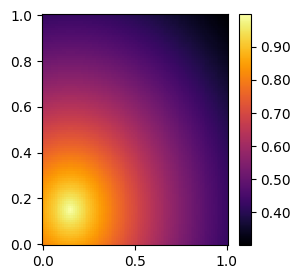

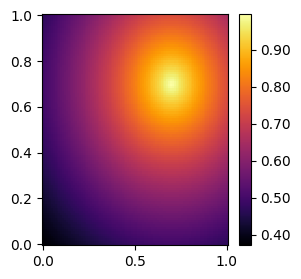

In [42]:
def u0_alt1(x):
    return jnp.exp(-jnp.linalg.norm(x - jnp.array([0.15, 0.7]), axis=-1))


jinns.plot.plot2d(
    fun=u0_alt1, xy_data=val_xy_data, title="u0_alt1(x,y)", figsize=(3, 3)
)


def u0_alt2(x):
    return jnp.exp(-jnp.linalg.norm(x - jnp.array([0.15, 0.15]), axis=-1))


jinns.plot.plot2d(
    fun=u0_alt2, xy_data=val_xy_data, title="u0_alt2(x,y)", figsize=(3, 3)
)


def u0_alt3(x):
    return jnp.exp(-jnp.linalg.norm(x - jnp.array([0.7, 0.7]), axis=-1))


jinns.plot.plot2d(
    fun=u0_alt3, xy_data=val_xy_data, title="u0_alt3(x,y)", figsize=(3, 3)
)

Initialization time: 3.2884721755981445

Compilation took
 13.213788747787476 

[train] Iteration 0: loss value = 1.1056952476501465
[train] Iteration 1000: loss value = 0.3808683156967163
[train] Iteration 2000: loss value = 0.21087150275707245
[train] Iteration 3000: loss value = 0.19230374693870544
[train] Iteration 4000: loss value = 0.2116142064332962
[train] Iteration 5000: loss value = 0.20460635423660278
[train] Iteration 6000: loss value = 0.13174143433570862
[train] Iteration 7000: loss value = 0.16579630970954895
[train] Iteration 8000: loss value = 0.19666659832000732
[train] Iteration 9000: loss value = 0.1786504089832306

Stopping main optimization loop, cause: max iteration is reached

Training took
 72.71434330940247 


Final iteration 10000: train loss value = 0.12345222383737564


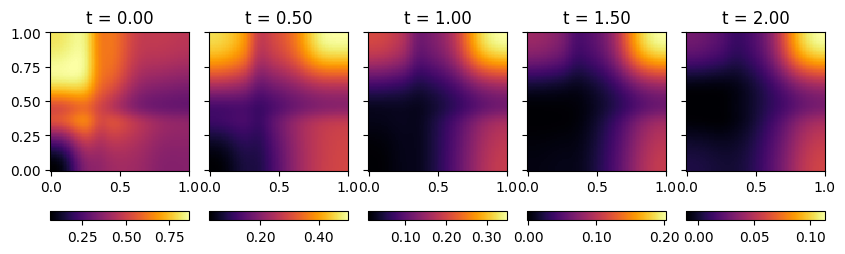

In [43]:
loss = jinns.loss.LossPDENonStatio(
    u=u_spinn,
    loss_weights=loss_weights,
    dynamic_loss=fisher_dynamic_loss,
    boundary_condition=jinns.loss.Neumann(),
    initial_condition_fun=u0_alt1,
    params=init_params,
)
params = init_params
params, total_loss_list, loss_by_term_dict, train_data, loss, _, _, _, _, _, _, _ = (
    jinns.solve(
        init_params=params,
        data=train_data,
        optimizer=tx,
        loss=loss,
        n_iter=n_iter,
    )
)
u_est = lambda t_x: u_spinn(t_x, params)
jinns.plot.plot2d(
    fun=u_est,
    xy_data=val_xy_data,
    times=times,
    Tmax=Tmax,
    figsize=(10, 10 * len(times)),
    spinn=True,
)

Initialization time: 3.298060655593872

Compilation took
 14.091060161590576 

[train] Iteration 0: loss value = 1.145430564880371
[train] Iteration 1000: loss value = 0.40161311626434326
[train] Iteration 2000: loss value = 0.3222781717777252
[train] Iteration 3000: loss value = 0.26022210717201233
[train] Iteration 4000: loss value = 0.30865466594696045
[train] Iteration 5000: loss value = 0.18230576813220978
[train] Iteration 6000: loss value = 0.1779910773038864
[train] Iteration 7000: loss value = 0.25619226694107056
[train] Iteration 8000: loss value = 0.17741858959197998
[train] Iteration 9000: loss value = 0.11952514946460724

Stopping main optimization loop, cause: max iteration is reached

Training took
 72.45676970481873 


Final iteration 10000: train loss value = 0.2865060567855835


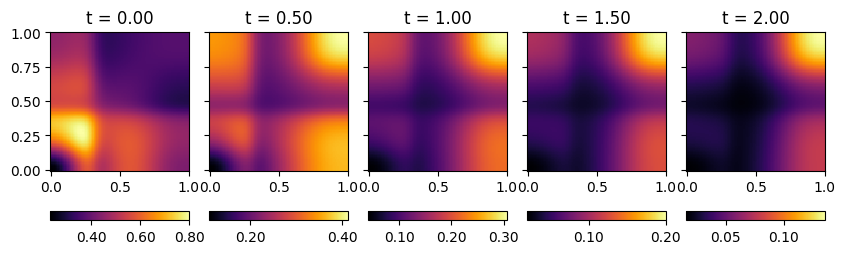

In [44]:
loss = jinns.loss.LossPDENonStatio(
    u=u_spinn,
    loss_weights=loss_weights,
    dynamic_loss=fisher_dynamic_loss,
    boundary_condition=jinns.loss.Neumann(),
    initial_condition_fun=u0_alt2,
    params=init_params,
)
params = init_params
params, total_loss_list, loss_by_term_dict, train_data, loss, _, _, _, _, _, _, _ = (
    jinns.solve(
        init_params=params,
        data=train_data,
        optimizer=tx,
        loss=loss,
        n_iter=n_iter,
    )
)
u_est = lambda t_x: u_spinn(t_x, params)
jinns.plot.plot2d(
    fun=u_est,
    xy_data=val_xy_data,
    times=times,
    Tmax=Tmax,
    figsize=(10, 10 * len(times)),
    spinn=True,
)

Initialization time: 3.235792875289917

Compilation took
 14.067701816558838 

[train] Iteration 0: loss value = 1.1078450679779053
[train] Iteration 1000: loss value = 0.3394956588745117
[train] Iteration 2000: loss value = 0.22152584791183472
[train] Iteration 3000: loss value = 0.2174701690673828
[train] Iteration 4000: loss value = 0.1407117396593094
[train] Iteration 5000: loss value = 0.1934490203857422
[train] Iteration 6000: loss value = 0.14605572819709778
[train] Iteration 7000: loss value = 0.15179085731506348
[train] Iteration 8000: loss value = 0.15725082159042358
[train] Iteration 9000: loss value = 0.15328019857406616

Stopping main optimization loop, cause: max iteration is reached

Training took
 72.50880908966064 


Final iteration 10000: train loss value = 0.1782507747411728


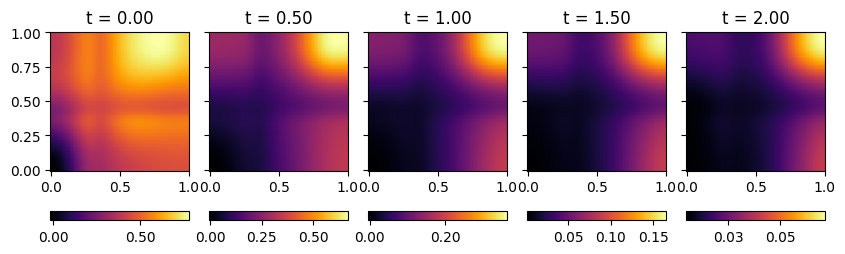

In [45]:
loss = jinns.loss.LossPDENonStatio(
    u=u_spinn,
    loss_weights=loss_weights,
    dynamic_loss=fisher_dynamic_loss,
    boundary_condition=jinns.loss.Neumann(),
    initial_condition_fun=u0_alt3,
    params=init_params,
)
params = init_params
params, total_loss_list, loss_by_term_dict, train_data, loss, _, _, _, _, _, _, _ = (
    jinns.solve(
        init_params=params,
        data=train_data,
        optimizer=tx,
        loss=loss,
        n_iter=n_iter,
    )
)
u_est = lambda t_x: u_spinn(t_x, params)
jinns.plot.plot2d(
    fun=u_est,
    xy_data=val_xy_data,
    times=times,
    Tmax=Tmax,
    figsize=(10, 10 * len(times)),
    spinn=True,
)

## 5) Conclusion

We have solved this Fisher KPP PDE tackling parameter heterogeneity and with both the PINN and SPINN approaches.

(Times obtained on GPU Nvidia T600)